In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from random import sample
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
import gc
import os

In [2]:
from lunar_lander import LunarLander
env = LunarLander('LunarLander-v2',
    continuous= False,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5.0,
    turbulence_power= 0.5)


In [3]:
env.action_space.n
env.observation_space.shape

(8,)

In [4]:

GAMMA = 0.99
LEARNING_RATE = 2.5e-4

MEMORY_SIZE = 1000000
BATCH_SIZE = 64

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [5]:
state_space=8
obs_space=8
action_space=4a
intermediate_dim=16

In [6]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,self.input_dim)))
        model.add(Dense(512,activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(256, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(128, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(self.output_dim, activation = 'linear',kernel_initializer='he_uniform'))
        model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        return model

In [7]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.97, 
                  memory_size = 10000,  C = 5,LEARNING_RATE=2.5e-5,GAMMA=1,EPSILON_MAX=1.0,EPSILON_MIN=0.01,BATCH_SIZE=64):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel(self.states, self.n_actions, self.lr)
        self.positive_rewards_list=[]
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
    def find_positive_rewards(self):
        self.positive_rewards_list=[]
        for i,x in enumerate(self.memory):
            if x[2]>10:
                self.positive_rewards_list.append(i)
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=self.decay_coe
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
        # indices=[]
        # minibatch=[]
        # if(len(self.positive_rewards_list)>10):
        #     indices=random.sample(self.positive_rewards_list,10)
        #     for i in indices:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-10)
        #     random.shuffle(minibatch)            
        #     return minibatch
        # else:
        #     for i in self.positive_rewards_list:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-len(self.positive_rewards_list))
        #     random.shuffle(minibatch)            
        #     return minibatch


    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            #X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
           #print(X.shape,"   ",y.shape  )                          
            #loss = self.model.Qpolicy.fit(final_dataset,verbose=0)   
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
           # print(self.model.Qpolicy.predict_on_batch(X))
           #print(X.shape,"   ",y.shape  )                          
            self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [8]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


In [9]:
scores=[]
no_train=[]


In [10]:
s=env.reset()
s=s[0]
print(s)

[ 0.00755339  1.4138441   0.76482594  0.12993601 -0.00854177 -0.16925961
  0.          0.        ]


In [11]:
s=[s[0],s[1],s[4],s[6],s[7]]
print(s)

[0.0075533865, 1.4138441, -0.0085417675, 0.0, 0.0]


In [12]:
#dqn_solver.memory[0]

In [13]:
#qn_solver.state_shape(dqn_solver.memory[0][0])

In [14]:
def training(dqn_solver,n_episodes=1000,maxt=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
     # last 100 scores
    trains=0
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state=state[0]
        score = 0

        done=False

        for t in tqdm(range(maxt),leave=False,desc=str(i_episode)):
            action = dqn_solver.act(state)
            next_state, reward, done, _,_ = env.step(action)
            
            dqn_solver.remember(state,action,reward,next_state,done)

            dqn_solver.train()
            trains+=1
            state = next_state
            score += reward
            if done:
                break
            
        dqn_solver.decrement_epsilon()
        scores.append(score)
        no_train.append(trains)             # save most recent score
        if(i_episode%5==0):
            dqn_solver.update_target_model()
        if(i_episode%20==0):
            print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score, end=""))




In [15]:
training(dqn_solver)

2:   0%|          | 0/1000 [00:00<?, ?it/s]         

KeyboardInterrupt: 

In [ ]:
scores

[-197.61841887472198,
 -462.6942075327624,
 -182.18388726389344,
 -190.81270383107156,
 -116.47435356065807,
 -236.2283774454045,
 -304.9011880934841,
 -87.24644502340239,
 -111.24205075832285,
 -78.57622547270557,
 -349.453981548544,
 -244.2187587809393,
 -410.5215103404855,
 -257.848259788827,
 -560.7042708251341,
 -239.65354058117987,
 -56.04071947845502,
 -217.3844837976922,
 -159.11438660347457,
 17.47997891097718,
 -354.95948657873794,
 -251.0336689539183,
 -62.15424850104842,
 -130.0515402477705,
 -50.40856725457107,
 -278.44602217257,
 -220.98099231898618,
 -260.50082642747384,
 -47.16086272416883,
 -141.81047065416288,
 -233.79764318515342,
 -110.00613153036376,
 -97.78945572231221,
 -338.81708026436763,
 -248.9520050433234,
 -110.90796935912341,
 -189.56667488050067,
 -265.64468947598755,
 -28.109067724288536,
 -118.29839951712164,
 -111.96942080298966,
 -199.87623076650294,
 -62.471282813151916,
 -236.70650266039928,
 -146.51292967339907,
 -97.7521709131125,
 -158.2725645464

In [16]:
import pandas as pd
df=pd.DataFrame(scores)
df.columns=['scores']
df.to_csv('rewards_only_dqn_normal_lunar_3.csv')

In [ ]:
df

,scores
0,-197.618419
1,-462.694208
2,-182.183887
3,-190.812704
4,-116.474354
...,...
495,-80.244408
496,-129.435473
497,-55.540610
498,-61.757400


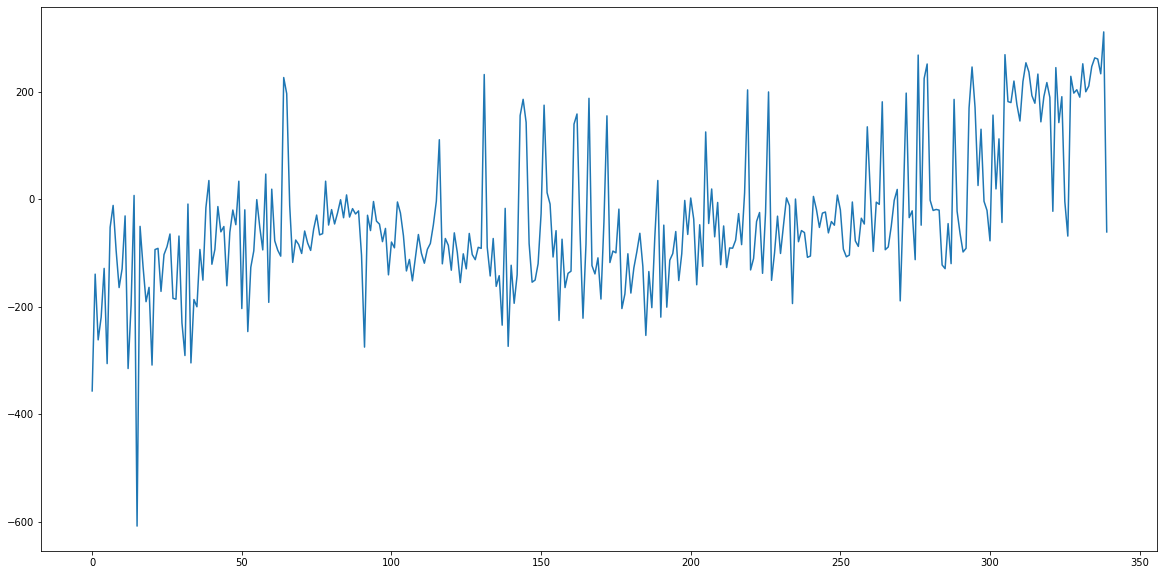

In [23]:
plt.plot(scores)

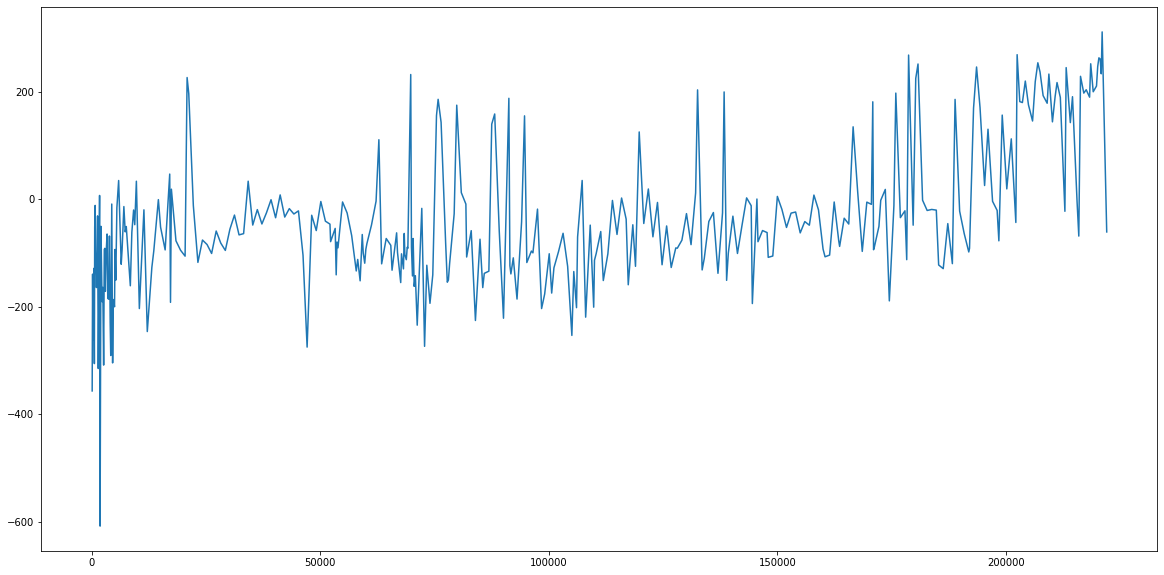

In [22]:
import matplotlib.pyplot as plt
plt.plot(no_train,scores)

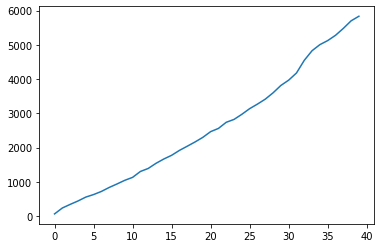

In [ ]:
plt.plot(no_train[0:40])

In [ ]:
ls=[]
for x in scores:
    if x>0:
        ls.append(x)
    else:
        ls.append(0.0)

In [19]:
df['positive']=ls
df['moving_avg']=df.scores.rolling(100,min_periods=1).mean()

NameError: name 'ls' is not defined

In [20]:
plt.rcParams['figure.figsize']=[20,10]

plt.plot(df['moving_avg'])

KeyError: 'moving_avg'

In [21]:
plt.plot(no_train,df['moving_avg'])

KeyError: 'moving_avg'